In [10]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

## Load and Preprocess Data

In [60]:
### RAW
# search_dirs = ["Dataset/Equities/", "Dataset/BondsFundsIndexes/"]
search_dirs = ["Dataset/Equities/"]
stock_dict = {}

for search_dir in search_dirs:
        for filename in os.listdir(search_dir):
            if filename.endswith('.csv'):
                stock_name = filename[:-4] 
                stock_dict[stock_name] = pd.read_csv(os.path.join(search_dir, filename))

In [66]:
### Preprocess
preprocessed_stocks = {}
stock_returns = {}
minmax_scalers = {}

for stock in stock_dict:
    stock_data = stock_dict[stock]
    stock_data = stock_data.drop(columns = ['Date'])
    
    scaler = MinMaxScaler()
    preprocessed_stock = scaler.fit_transform(stock_data)
    minmax_scalers[stock] = scaler
    
    preprocessed_stock = pd.DataFrame(preprocessed_stock, columns=stock_data.columns, index=stock_data.index)
    preprocessed_stocks[stock]=preprocessed_stock
    
    

In [67]:
print(len(stock_dict.keys()))

39


In [68]:
### Form time series
def create_time_series_data(stock_data, window_size=60):
    """
    Turn raw data into sliding window prediction.

    - stock_data: (num_days,num_features)
    - window_size: number of days to use for prediction

    
    Return
    - X: nparray um_samples, window_size, num_features)
    - y: nparray (num_samples,)
    """
    num_days = stock_data.shape[0]
    X = []
    y = []

    for i in range(num_days - window_size):
        X.append(stock_data.iloc[i:i+window_size].values)
#         print(stock_data.iloc[i:i+window_size].values.shape)
        
        ### Target Variable: Closing Price
        close_day = data['Close'].iloc[i+window_size]
        y.append(close_day)

    X = np.array(X)
    y = np.array(y)
    
    return X, y

stock_60d = {}
stock_1d = {}

for stock, data in preprocessed_stocks.items():
    stock_60d[stock], stock_1d[stock] = create_time_series_data(data)



## Define Models

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [70]:
class DMLPModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=15, num_hidden_layers=6, output_dim=1):
        super(DMLPModel, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 60 * 6)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x


class LSTMModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=50, num_layers=4, output_dim=1, dropout_rate=0.4, recurrent_dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=recurrent_dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  
        out = self.fc(out)
        return out
    
class CNNModel(nn.Module):
    def __init__(self, input_dim=6, output_dim=1, num_filters=2, kernel_size=2, hidden_dim=2):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=kernel_size)
        self.fc1 = nn.Linear(num_filters * (input_dim // 2 - 1), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
 
def RandomForestModel(n_estimators=500, max_depth=20,min_samples_split=10,min_samples_leaf=10,max_features=40):
    return RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features
                                   )

def SVRModel(C=2**2, gamma=2**-3):
    return SVR(kernel='rbf', C=C, gamma=gamma)

## Train & Evaluate

In [71]:
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, num_epochs=100, patience=0, device='cpu', print_every=5):
    best_loss = float('inf')
    patience_counter = 0
    val_loss = 0
    
    model.to(device)
    print_every = print_every
    
    for epoch in range(num_epochs):
        model.train()

        X_train = X_train.to(device)
        y_train = y_train.to(device).view(-1,1)
        X_val = X_val.to(device)
        y_val = y_val.to(device).view(-1,1)
        

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        
        if epoch % print_every ==0:
            print(f"Epoch {epoch}/{num_epochs - 1}, Training Loss: {loss:.6f}")
        
        # Early stopping
            model.eval()
            with torch.no_grad():
                outputs = model(X_val)
                
                loss = criterion(outputs, y_val)
                val_loss = loss

                print(f"Validation Loss: {loss:.6f}")

#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 best_model_wts = model.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

    #         if patience_counter > patience:
    #             print("Early stopping")
    #             break
    
#     model.load_state_dict(best_model_wts)
    return model, val_loss

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_test, X_val, y_train, y_val, y_test = {}, {}, {}, {}, {}, {}

# 6-2-2 split
for stock in stock_60d:
    x_train_temp, X_test[stock], y_train_temp, y_test[stock] = train_test_split(stock_60d[stock], stock_1d[stock], test_size=0.2, random_state=1)
    X_train[stock], X_val[stock], y_train[stock], y_val[stock] = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=1)

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensors = {stock: to_tensor(X_train[stock]) for stock in X_train}
X_val_tensors = {stock: to_tensor(X_val[stock]) for stock in X_val}
X_test_tensors = {stock: to_tensor(X_test[stock]) for stock in X_test}
y_val_tensors = {stock: to_tensor(y_val[stock]) for stock in y_val}
y_train_tensors = {stock: to_tensor(y_train[stock]) for stock in y_train}
y_test_tensors = {stock: to_tensor(y_test[stock]) for stock in y_test}

print(y_test_tensors['DEO'].shape, y_train_tensors['DEO'].shape, y_val_tensors['DEO'].shape)

torch.Size([492]) torch.Size([1474]) torch.Size([492])


In [73]:
#DMLP
dmlp_models = {}
num_epochs = 500
learning_rate = 0.01
input_size = 6

test_losses = []
val_losses = []

for stock in X_train_tensors:
    print("model DMLP: " + stock)
#     model = LSTMModel(input_dim=input_size, hidden_dim=40)
    model = DMLPModel(input_dim=60 * input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trained_model, val_loss = train_model(model, X_train_tensors[stock], y_train_tensors[stock], X_val_tensors[stock], y_val_tensors[stock], criterion, optimizer, num_epochs, patience=0, device=device, print_every=50)
    val_losses.append(val_loss.item())
    #Test
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(X_test_tensors[stock].to(device))
        loss = criterion(outputs, y_test_tensors[stock].to(device).view(-1,1))

        print(f"Test Loss: {loss:.6f}")
        test_losses.append(loss.item())
    dmlp_models[stock] = trained_model

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model DMLP: MSBHF
Epoch 0/499, Training Loss: 0.038234
Validation Loss: 0.033777
Epoch 50/499, Training Loss: 0.000490
Validation Loss: 0.000483
Epoch 100/499, Training Loss: 0.000395
Validation Loss: 0.000417
Epoch 150/499, Training Loss: 0.000256
Validation Loss: 0.000229
Epoch 200/499, Training Loss: 0.000222
Validation Loss: 0.000202
Epoch 250/499, Training Loss: 0.000351
Validation Loss: 0.000198
Epoch 300/499, Training Loss: 0.000173
Validation Loss: 0.000162
Epoch 350/499, Training Loss: 0.000207
Validation Loss: 0.000221
Epoch 400/499, Training Loss: 0.000154
Validation Loss: 0.000149
Epoch 450/499, Training Loss: 0.000142
Validation Loss: 0.000136
Test Loss: 0.000245
model DMLP: IPGP
Epoch 0/499, Training Loss: 0.209837
Validation Loss: 0.168091
Epoch 50/499, Training Loss: 0.004589
Validation Loss: 0.004571
Epoch 100/499, Training Loss: 0.002010
Validation Loss: 0.001929
Epoch 150/499, Training Loss: 0.001379
Validation Loss: 0.001354
Epoch 200/499, Training Loss: 0.000983
Va

In [74]:
#LSTM
lstm_models = {}
num_epochs = 500
learning_rate = 0.01
input_size = 6

test_losses = []
val_losses = []

for stock in X_train_tensors:
    print("model LSTM: " + stock)
    model = LSTMModel(input_dim=input_size, hidden_dim=40)
#     model = DMLPModel(input_dim=60 * input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trained_model, val_loss = train_model(model, X_train_tensors[stock], y_train_tensors[stock], X_val_tensors[stock], y_val_tensors[stock], criterion, optimizer, num_epochs, patience=0, device=device, print_every=20)
    val_losses.append(val_loss.item())
    #Test
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(X_test_tensors[stock].to(device))
        loss = criterion(outputs, y_test_tensors[stock].to(device).view(-1,1))

        print(f"Test Loss: {loss:.6f}")
        test_losses.append(loss.item())
    lstm_models[stock] = trained_model

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model LSTM: MSBHF
Epoch 0/499, Training Loss: 0.062385
Validation Loss: 0.034008
Epoch 20/499, Training Loss: 0.005605
Validation Loss: 0.002494
Epoch 40/499, Training Loss: 0.002668
Validation Loss: 0.000322
Epoch 60/499, Training Loss: 0.001991
Validation Loss: 0.000888
Epoch 80/499, Training Loss: 0.001420
Validation Loss: 0.000425
Epoch 100/499, Training Loss: 0.001164
Validation Loss: 0.000307
Epoch 120/499, Training Loss: 0.001188
Validation Loss: 0.000293
Epoch 140/499, Training Loss: 0.001133
Validation Loss: 0.000289
Epoch 160/499, Training Loss: 0.001154
Validation Loss: 0.000231
Epoch 180/499, Training Loss: 0.000983
Validation Loss: 0.000228
Epoch 200/499, Training Loss: 0.001015
Validation Loss: 0.000278
Epoch 220/499, Training Loss: 0.000936
Validation Loss: 0.000281
Epoch 240/499, Training Loss: 0.001000
Validation Loss: 0.000206
Epoch 260/499, Training Loss: 0.000981
Validation Loss: 0.000228
Epoch 280/499, Training Loss: 0.001020
Validation Loss: 0.000260
Epoch 300/499

In [75]:
# RF
rf_models = {}
test_losses = []
val_losses = []
input_size = 6

for stock in stock_60d:
    print("model RF: " + stock)
    model_rf = RandomForestModel()
    model_rf.fit(X_train[stock].reshape(-1,60 * input_size), y_train[stock])

    y_train_pred_rf = model_rf.predict(X_train[stock].reshape(-1,60 * input_size))
    y_val_pred_rf = model_rf.predict(X_val[stock].reshape(-1,60 * input_size))
    y_test_pred_rf = model_rf.predict(X_test[stock].reshape(-1,60 * input_size))

    train_error_rf = mean_squared_error(y_train[stock], y_train_pred_rf)
    val_error_rf = mean_squared_error(y_val[stock], y_val_pred_rf)
    test_error_rf = mean_squared_error(y_test[stock], y_test_pred_rf)
    
    rf_models[stock] = model_rf
    
    val_losses.append(val_error_rf)
    test_losses.append(test_error_rf)
        
    print(f"{stock} - Train Error: {train_error_rf:.6f}, Val Error: {val_error_rf:.6f}, Test Error: {test_error_rf:.6f}")

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model RF: MSBHF
MSBHF - Train Error: 0.000084, Val Error: 0.000095, Test Error: 0.000146
model RF: IPGP
IPGP - Train Error: 0.000250, Val Error: 0.000567, Test Error: 0.000484
model RF: IRM
IRM - Train Error: 0.000116, Val Error: 0.000177, Test Error: 0.000194
model RF: LVMUY
LVMUY - Train Error: 0.000101, Val Error: 0.000154, Test Error: 0.000188
model RF: QCOM
QCOM - Train Error: 0.000179, Val Error: 0.000278, Test Error: 0.000344
model RF: DE
DE - Train Error: 0.000125, Val Error: 0.000174, Test Error: 0.000214
model RF: META
META - Train Error: 0.000125, Val Error: 0.000166, Test Error: 0.000116
model RF: GOOGL
GOOGL - Train Error: 0.000101, Val Error: 0.000136, Test Error: 0.000152
model RF: MRK
MRK - Train Error: 0.000115, Val Error: 0.000210, Test Error: 0.000186
model RF: WFC
WFC - Train Error: 0.000255, Val Error: 0.000475, Test Error: 0.000482
model RF: PEP
PEP - Train Error: 0.000151, Val Error: 0.000211, Test Error: 0.000269
model RF: MDLZ
MDLZ - Train Error: 0.000175, Val 

In [76]:
# SVR
SVR_models = {}
test_losses = []
val_losses = []
input_size = 6

for stock in stock_60d:
    print("model RF: " + stock)
    model_svr = SVRModel()
    model_svr.fit(X_train[stock].reshape(-1,60 * input_size), y_train[stock])

    y_train_pred_svr = model_svr.predict(X_train[stock].reshape(-1,60 * input_size))
    y_val_pred_svr = model_svr.predict(X_val[stock].reshape(-1,60 * input_size))
    y_test_pred_svr = model_svr.predict(X_test[stock].reshape(-1,60 * input_size))

    train_error_svr = mean_squared_error(y_train[stock], y_train_pred_svr)
    val_error_svr = mean_squared_error(y_val[stock], y_val_pred_svr)
    test_error_svr = mean_squared_error(y_test[stock], y_test_pred_svr)
    
    SVR_models[stock] = model_svr
    
    val_losses.append(val_error_svr)
    test_losses.append(test_error_svr)
        
    print(f"{stock} - Train Error: {train_error_svr:.6f}, Val Error: {val_error_svr:.6f}, Test Error: {test_error_svr:.6f}")

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model RF: MSBHF
MSBHF - Train Error: 0.001123, Val Error: 0.001034, Test Error: 0.001166
model RF: IPGP
IPGP - Train Error: 0.002215, Val Error: 0.002336, Test Error: 0.002381
model RF: IRM
IRM - Train Error: 0.001698, Val Error: 0.001645, Test Error: 0.001824
model RF: LVMUY
LVMUY - Train Error: 0.002365, Val Error: 0.002171, Test Error: 0.002158
model RF: QCOM
QCOM - Train Error: 0.001746, Val Error: 0.001690, Test Error: 0.001769
model RF: DE
DE - Train Error: 0.002288, Val Error: 0.002223, Test Error: 0.002372
model RF: META
META - Train Error: 0.001926, Val Error: 0.002075, Test Error: 0.001836
model RF: GOOGL
GOOGL - Train Error: 0.002536, Val Error: 0.002630, Test Error: 0.002416
model RF: MRK
MRK - Train Error: 0.001724, Val Error: 0.001693, Test Error: 0.001752
model RF: WFC
WFC - Train Error: 0.002282, Val Error: 0.002223, Test Error: 0.002511
model RF: PEP
PEP - Train Error: 0.002297, Val Error: 0.002197, Test Error: 0.002144
model RF: MDLZ
MDLZ - Train Error: 0.001929, Val 

In [ ]:
# # Save Models
# import pickle


# if not os.path.exists('Prediction_Models/'):
#     os.makedirs('Prediction_Models/')

# for 
# # save
# with open('model.pkl','wb') as f:
#     pickle.dump(clf,f)

# # load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

# clf2.predict(X[0:1])

### Mean test error (Next-day Closing Price Prediction)
Note: Closing Price is standardized
* SVR (2.2 * 10-3)
* **RF (2.8 * 10-4)**
* LSTM (4.6 * 10-4)
* DMLP (5.3 * 10-4)

# Prediction Visulization

In [77]:
# print(stock_60d.keys())
sample_stocks = np.random.choice(list(stock_60d.keys()), 5)
print("Visulazation Sample Stocks:", sample_stocks)


Visulazation Sample Stocks: ['PG' 'DEO' 'DE' 'SBUX' 'V']


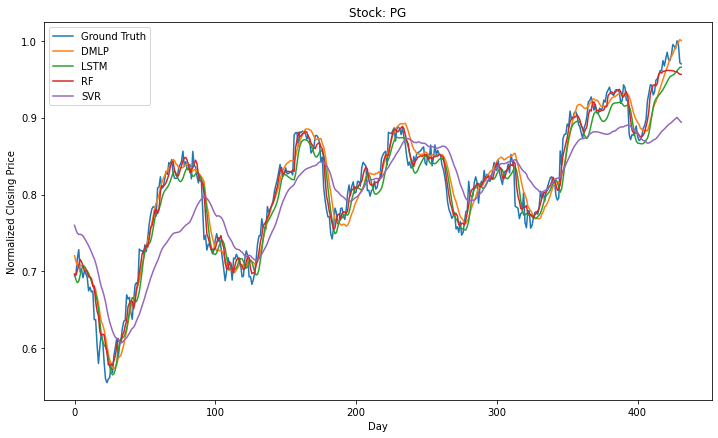

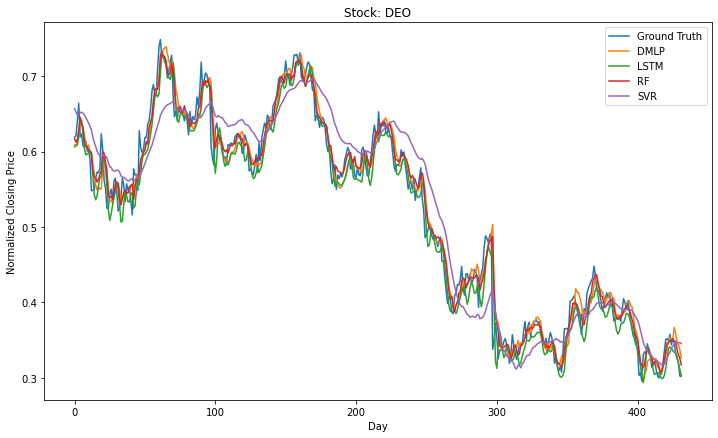

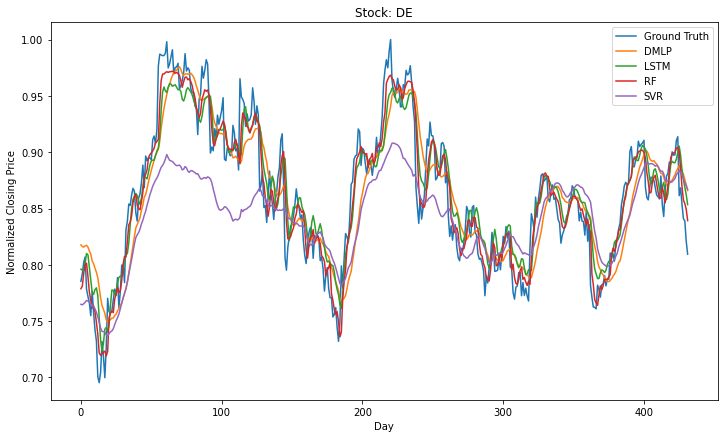

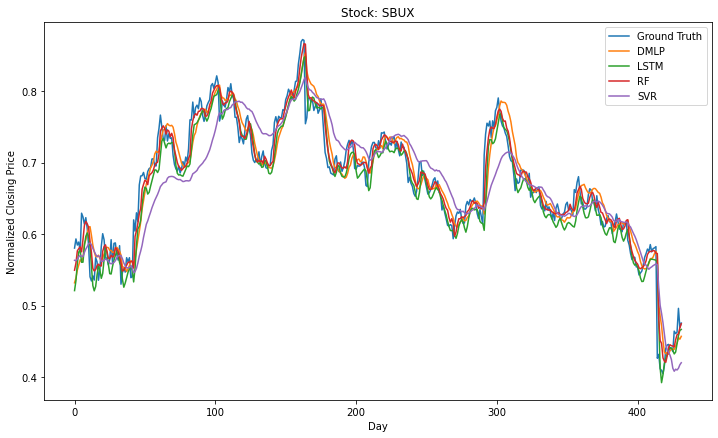

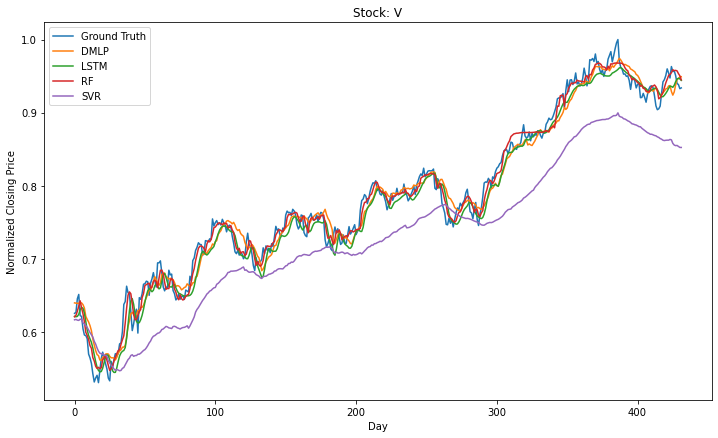

In [144]:
## Visualize each Model's Performance on Sample Stocks
for stock in sample_stocks:
    dmlp_model = dmlp_models[stock]
    lstm_model = lstm_models[stock]
    rf_model = rf_models[stock]
    svr_model = SVR_models[stock]
    
    #Plot Ground Truth
    plt.figure(figsize=(10,6))
    plt.title("Stock: " + stock)
    plt.tight_layout()
    # Ground Truth (Standardized)
    GT_closing = preprocessed_stocks[stock]['Close'].iloc[-y_test[stock].shape[0]+60:]
    plt.plot(np.arange(GT_closing.size), np.array(GT_closing), label='Ground Truth')
    
    def predict_closing_prices(model, stock_data, is_tensor = True):
        prediction = None
        time_series, _ = create_time_series_data(stock_data)

        if is_tensor:
            model.eval()
            time_series = torch.tensor(time_series, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                prediction = model(time_series)
                prediction = prediction.cpu().numpy()
        else:
            prediction = model.predict(time_series.reshape(-1,60 * input_size))
                
        return prediction
    
    
    test_data = preprocessed_stocks[stock].iloc[-y_test[stock].shape[0]:]
    
    #Plot DMLP Prediction
    dmlp_predictions = predict_closing_prices(dmlp_model, test_data)
    plt.plot(np.arange(GT_closing.size), dmlp_predictions, label='DMLP')
    
    #Plot LStM Prediction
    lstm_predictions = predict_closing_prices(lstm_model, test_data)
    plt.plot(np.arange(GT_closing.size), lstm_predictions, label='LSTM')
    
    #Plot RF Prediction
    rf_predictions = predict_closing_prices(rf_model, test_data, False)
    plt.plot(np.arange(GT_closing.size), rf_predictions, label='RF')
    
    #Plot SVR Prediction
    svr_predictions = predict_closing_prices(svr_model, test_data, False)
    plt.plot(np.arange(GT_closing.size), svr_predictions, label='SVR')
    
    plt.xlabel('Day')
    plt.ylabel('Normalized Closing Price')
    plt.legend()
    plt.savefig(stock+'.png', dpi=300)
    plt.show()

# def predict_next_day_return(model, data):
#     model.eval()
#     last_sequence = data[-seq_length:]
#     last_sequence = torch.tensor(last_sequence.values, dtype=torch.float32).unsqueeze(0).to(device)
#     with torch.no_grad():
#         prediction = model(last_sequence)
#     return prediction.item()

# predicted_returns = {}
# for stock, model in models.items():
#     predicted_returns[stock] = predict_next_day_return(model, preprocessed_data[stock])

# investment_strategy = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
# print("Investment Strategy:")
# for stock, predicted_return in investment_strategy:
#     print(f"Invest in {stock}: Predicted Return = {predicted_return:.4f}")

# investment_stocks = [stock for stock, _ in investment_strategy[:5]]  # Choose top 5 stocks to invest in

# plt.figure(figsize=(14, 7))

# for stock in investment_stocks:
#     data = stock_data[stock]
#     data['Date'] = pd.to_datetime(data['Date'])
#     data.set_index('Date', inplace=True)
#     plt.plot(data.index, data['Close'], label=f"{stock} Close Price")

# plt.title("Stock Prices of Selected Stocks to Invest In")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))

# predicted_returns_sorted = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
# stocks = [stock for stock, _ in predicted_returns_sorted]
# returns = [predicted_return for _, predicted_return in predicted_returns_sorted]

# plt.bar(stocks, returns, color='green')
# plt.title("Predicted Returns for the Next Day")
# plt.xlabel("Stocks")
# plt.ylabel("Predicted Return")
# plt.xticks(rotation=45)
# plt.show()

# Mean Variance Optimization


In [81]:
# Get the prediction return over time for all models
def prediction_2_returns(predictions):
    returns = np.diff(predictions) / predictions[:-1]
    return returns


predict_return_dict = {}
predict_error_dict = {}
GT_return_dict = {}

models = ['DMLP', 'LSTM', 'RF', 'SVR']

idx = 0




for model_n in models:
    predict_return_dict[model_n] = {}
    predict_error_dict[model_n] = {}
    
    print(model_n)
    for stock in stock_60d:
        if model_n == 'DMLP':
            model = dmlp_models[stock]
            is_tensor = True
        elif model_n == "LSTM":
            model = lstm_models[stock]
            is_tensor = True
        elif model_n == "RF":
            model = rf_models[stock]
            is_tensor = False
        elif model_n == "SVR":
            model = SVR_models[stock]
            is_tensor = False
        
        
        def predict_closing_prices(model, stock_data, is_tensor = True):
            prediction = None
            time_series, _ = create_time_series_data(stock_data)

            if is_tensor:
                model.eval()
                time_series = torch.tensor(time_series, dtype=torch.float32).to(device)
                
                with torch.no_grad():
                    prediction = model(time_series)
                    prediction = prediction.cpu().numpy()
            else:
                prediction = model.predict(time_series.reshape(-1,60 * input_size))
                    
            return prediction
        
        
        test_data = preprocessed_stocks[stock].iloc[-y_test[stock].shape[0]:]
        
        
        # 431 days
        #Plot DMLP Prediction
        predictions = predict_closing_prices(model, test_data, is_tensor = is_tensor)
        predictions = np.reshape(predictions, predictions.shape[0])
        returns = prediction_2_returns(predictions)
        
        # Ground Truth (Standardized)
        GT_closing = preprocessed_stocks[stock]['Close'].iloc[-y_test[stock].shape[0]+60:]
        GT_return = prediction_2_returns(GT_closing)
        # GT_closing = GT_closing / GT_closing[0]
        
        
        predict_return_dict[model_n][stock] = returns
        predict_error_dict[model_n][stock] = GT_return - returns
        if stock not in GT_return_dict:
            GT_return_dict[stock] = GT_return

# print(predict_error_dict)
# print(predict_return_dict)


DMLP
LSTM
RF
SVR


In [127]:
#MVO
sample_period = 20
window_size = 60
risk_scale = 0.5 # higher the safer

weight_dict = {}
daily_returns = {}
net_values = {}

for model_n in models:
    weight_dict[model_n] = []
    daily_returns[model_n] = []
    net_values[model_n] = []
    
    stock_return_dict = predict_return_dict[model_n]
    stock_error_dict = predict_error_dict[model_n]
    
    for day in range(len(GT_return) - window_size):
        average_errors = {stock: np.mean(stock_error_dict[stock][window_size - sample_period + day : window_size + day]) for stock in stock_60d.keys()}
        average_errors_vector = np.array([average_errors[stock] for stock in stock_60d.keys()]) # (39,)
        
        returns_matrix = np.array([GT_return_dict[stock][day:window_size + day] for stock in stock_60d.keys()]) # (39,60)
        cov_matrix = np.cov(returns_matrix) # (39,39)

        
        predicted_returns_vector = np.array([stock_return_dict[stock][window_size + day] for stock in stock_60d.keys()])
        
        n=predicted_returns_vector.shape[0]

        
        def objective(weights):
            # risk = weights.T @ cov_matrix @ weights
            # expected_return = predicted_returns_vector @ weights
            # predictive_error_reduction = average_errors_vector @ weights
            return risk_scale * np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) - (1 - risk_scale) * np.sum(predicted_returns_vector * weights) - np.sum(average_errors_vector * weights)

        # Constraints
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights is 1
        )

        # Bounds for weights
        bounds = [(0, 1) for _ in range(n)]

        # Initial guess (equal weights)
        initial_guess = np.ones(n) / n

        from scipy.optimize import minimize
        
        # Solve the optimization problem
        result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

        # Display the optimal portfolio weights
        # print("Optimal portfolio weights:")
        # print(result.x)

        # Check if the optimization was successful
        wt = result.x
        
        for i in range(len(wt)):
            if wt[i] < 1e-5:
                wt[i] = 0
        
        wt = np.array(wt, dtype=np.float128)
        actual_returns = np.array([GT_return_dict[stock].iloc[window_size + day] for stock in stock_60d.keys()])
        # net_return = np.dot(wt, )
        # print(np.sum(wt))
        net_return = np.sum(wt * actual_returns)

        
        weight_dict[model_n].append(wt)
        # print(wt)
        
        daily_returns[model_n].append(net_return)
    
        
        # if result.success:
        #     print("Optimal value:", result.fun)
        # else:
        #     print("The problem is not solvable.")

    for i in range(len(daily_returns[model_n])):
        day_return = daily_returns[model_n][i]
        if len(net_values[model_n]) == 0:
            net_values[model_n].append(1+day_return)
        else:
            last_netValue = net_values[model_n][-1]
            net_values[model_n].append((1+day_return)*last_netValue)

print(net_values)
        

        

/tmp/ipykernel_3652926/4201845313.py:68: RuntimeWarning: invalid value encountered in multiply
  net_return = np.sum(wt * actual_returns)
/home/six004/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


{'DMLP': [1.0494440187531730053, 1.0288848398778967163, 0.88492891679633114765, 0.8708544104644454213, 0.8737452345575257027, 0.8576886584535228808, 0.8861995260545560795, 0.8965903416512509855, 0.88060538061483809177, 0.85559288100719013193, 0.8411906575247791915, 0.8370822129163034639, 0.8432951769272597398, 0.8558426827373436193, 0.8486909931423227084, 1.0034188346430507917, 1.0008333825977831896, 0.979740209574160191, 0.9826063306957392322, 0.94510189723165159313, 1.206380670969490255, 1.2408937321512496348, 1.2350122305119750952, 1.4310459490112908072, 1.4109924830194287777, 1.4834400226950349262, 1.5006978636917234488, 1.506702720326066545, 1.524531458981241308, 1.4315689913656372718, 1.3845176877059604457, 1.3435092433437607258, 1.3477162741259879369, 1.416263460599658207, 1.4069214707425391203, 1.4109326343101896214, 1.4297219397530522837, 1.4581607139270076738, 1.4150961817861880155, 1.4352504062224301811, 1.4386224286869656945, 1.4328823424095801263, 1.3907268971889909189, 1.

In [122]:
print(stock_60d.keys())

dict_keys(['MSBHF', 'IPGP', 'IRM', 'LVMUY', 'QCOM', 'DE', 'META', 'GOOGL', 'MRK', 'WFC', 'PEP', 'MDLZ', 'LH', 'DIS', 'GS', 'NTDOY', 'STZ', 'MSFT', 'AAPL', 'ULTA', 'DLR', 'SBUX', 'HCA', 'GOOG', 'JCI', 'MCD', 'BAC', 'NVDA', 'PG', 'CME', 'LMT', 'BA', 'UNH', 'DEO', 'ORCL', 'BRK-B', 'ARE', 'V', 'ADM'])


DMLP net_value 2.0557350002531970354
LSTM net_value 0.68640609197159874167
RF net_value 4.799889596389911141
SVR net_value 0.5587169143706603648


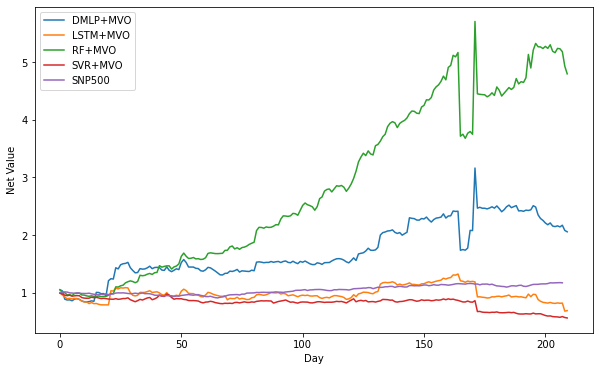

<Figure size 432x288 with 0 Axes>

In [145]:

# Load the csv file
file_path = 'Dataset/SNP500.csv'
data = pd.read_csv(file_path)

# Select rows 12 to 382 (inclusive) for the Closing date prices
selected_data = data.iloc[12:220]['Close']


# Convert the selected data to a numpy array
closing_prices_array = selected_data.to_numpy()[::-1]
closing_prices_array = closing_prices_array / closing_prices_array[0]


plt.figure(figsize=(10,6))
plt.xlabel('Day')
plt.ylabel('Net Value')
for model_n in models:
    net_value = net_values[model_n]
    plt.plot(net_value, label=model_n+ "+MVO")
    print(model_n, 'net_value', net_value[209])
plt.plot(closing_prices_array, label="SNP500")
plt.legend()
plt.show()

plt.savefig('MVO.png',dpi=300)